# Developing a Classifier for Movie Rating for IMDB Data Set

## Section 0: Load Dependencies and Data

In [20]:
import pandas as pd  # For data manipulation and analysis
from collections import Counter  # For counting hashable objects
from sklearn.decomposition import PCA  # For dimensionality reduction
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
from sklearn.feature_selection import mutual_info_classif  # For feature importance estimation
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier for SVM
from sklearn.model_selection import KFold  # For k-fold cross-validation
import statistics as stat  # For statistical calculations
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.cross_decomposition import PLSRegression  # Partial Least Squares regression
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix,f1_score, balanced_accuracy_score  # For calculating R-squared metric
import random  # For generating random numbers
from sklearn.model_selection import GridSearchCV  # For hyperparameter optimization
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier



# Loading the datasets for training and testing
try:
    Test = pd.read_csv('project_data/test_dataset.csv')  # Test dataset
    Train = pd.read_csv('project_data/train_dataset.csv')  # Training dataset
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure the file paths are correct.")
    raise
except pd.errors.EmptyDataError as e:
    print(f"Error: {e}. Ensure the CSV files are not empty.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while loading datasets: {e}")
    raise



# Validating the datasets
def validate_dataset(df, name):
    print(f"\nValidating {name} dataset:")
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Warning: Missing values detected.")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values detected.")
    
    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"Warning: {duplicate_count} duplicate rows found.")
    else:
        print("No duplicate rows detected.")
    
    # Check for feature consistency
    print("Dataset shape:", df.shape)
    if df.empty:
        print(f"Error: {name} dataset is empty.")
        raise ValueError(f"{name} dataset is empty.")
    elif len(df.columns) == 0:
        print(f"Error: {name} dataset has no columns.")
        raise ValueError(f"{name} dataset has no columns.")
    else:
        print(f"{name} dataset structure is valid.")
    
    # Display basic statistics for numeric columns
    print("Basic statistics:")
    print(df.describe())

# Validate both Train and Test datasets
validate_dataset(Train, "Training")
validate_dataset(Test, "Testing")

print("\nValidation complete.")


Datasets loaded successfully!

Validating Training dataset:
language    1
dtype: int64
No duplicate rows detected.
Dataset shape: (3004, 27)
Training dataset structure is valid.
Basic statistics:
               id  num_critic_for_reviews     duration  \
count  3004.00000             3004.000000  3004.000000   
mean   1502.50000              165.609188   110.076565   
std     867.32443              121.254549    21.910608   
min       1.00000                2.000000    37.000000   
25%     751.75000               76.000000    96.000000   
50%    1502.50000              137.000000   106.000000   
75%    2253.25000              223.000000   120.000000   
max    3004.00000              813.000000   330.000000   

       director_facebook_likes  actor_3_facebook_likes  \
count              3004.000000             3004.000000   
mean                778.890146              767.860186   
std                2990.741946             1901.991202   
min                   0.000000                0.0

In [2]:
import numpy as np
import pandas as pd


# Load plot keyword embeddings (Doc2Vec representation)
KWEembeddings = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_plot_keywords.npy")

# Load genre embeddings (Doc2Vec representation)
Gembeddings = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_genre.npy")

# Load title embeddings (FastText representation)
Tembeddings = np.load("project_data/features_fasttext/features_fasttext/train_fasttext_title_embeddings.npy")


KeyWordEmbeddings = pd.DataFrame(KWEembeddings).add_prefix("KWE_")
GenreEmbeddings    = pd.DataFrame(Gembeddings).add_prefix("GenEmb_")
TitleEmbeddings    = pd.DataFrame(Tembeddings).add_prefix("TitleEmb_")


print("Shape of KeyWordEmbeddings:", KeyWordEmbeddings.shape)
print("Shape of GenreEmbeddings:", GenreEmbeddings.shape)
print("Shape of TitleEmbeddings:", TitleEmbeddings.shape)



Shape of KeyWordEmbeddings: (3004, 100)
Shape of GenreEmbeddings: (3004, 100)
Shape of TitleEmbeddings: (3004, 100)


## Section 1: Pre-processing, and exploratory analysis

### 1.1: Analyzing Genre Distribution and Frequency

In [3]:
# Split the "genres" column into a list of genres for each movie
Train["genres"] = Train["genres"].apply(lambda x: x.split("|"))

# Initialize an empty list to store all genre occurrences
genreFreqList = []

# Flatten the nested list of genres to prepare for frequency calculation
for genres in Train["genres"]:
    for genre in genres:
        genreFreqList.append(genre)

# Count the occurrences of each genre using Counter
count = Counter(genreFreqList)
print("Genre Frequency Count:", count)  # Output the genre frequency count
print("Number of unique genres:", len(count))  # Output the number of unique genres

# Function to one-hot encode genres for each row
def OneHotEncodeGenre(row):
    """
    Updates the row's genre columns with one-hot encoding.
    Each genre column value is incremented by 1 if the genre is present in the row.

    Parameters:
    row (Series): A row of the DataFrame containing a list of genres.

    Returns:
    Series: Updated row with one-hot encoded genre columns.
    """
    for genre in row["genres"]:  # Iterate over genres in the current row
        row[genre] += 1  # Increment the respective genre column
    return row

# Get the list of unique genres as column labels
labels = list(count.keys())

# Create a DataFrame with one column per genre, initialized to 0
EncodedGenres = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels)

# Copy the "genres" column from the original Train dataset to preserve genre lists
EncodedGenres["genres"] = Train["genres"].copy(deep=True)

print("Initial one-hot encoded DataFrame (before processing):")
print(EncodedGenres)

# Apply the one-hot encoding function to each row of the DataFrame
EncodedGenres = EncodedGenres.apply(lambda x: OneHotEncodeGenre(x), axis=1)

# Drop the now-unnecessary "genres" column as the data has been encoded
EncodedGenres = EncodedGenres.drop(columns=["genres"])

# Output the final one-hot encoded DataFrame
print("Final one-hot encoded DataFrame (after processing):")
print(EncodedGenres)


Genre Frequency Count: Counter({'Drama': 1505, 'Comedy': 1175, 'Thriller': 884, 'Action': 765, 'Romance': 699, 'Adventure': 612, 'Crime': 568, 'Fantasy': 405, 'Sci-Fi': 388, 'Family': 354, 'Horror': 321, 'Mystery': 306, 'Biography': 194, 'Animation': 146, 'War': 127, 'Music': 126, 'History': 125, 'Sport': 114, 'Musical': 79, 'Western': 41, 'Documentary': 37, 'Film-Noir': 1})
Number of unique genres: 22
Initial one-hot encoded DataFrame (before processing):
      Adventure  Animation  Drama  Family  Musical  Horror  Mystery  Sci-Fi  \
0             0          0      0       0        0       0        0       0   
1             0          0      0       0        0       0        0       0   
2             0          0      0       0        0       0        0       0   
3             0          0      0       0        0       0        0       0   
4             0          0      0       0        0       0        0       0   
...         ...        ...    ...     ...      ...     ...      .

### 1.3 Content Rating Transformation

In [4]:
from collections import Counter

# Extract content ratings from the dataset
ratings = Train["content_rating"]

# Generate a frequency list of ratings for analysis
ratingsFreqList = [rating for rating in Train["content_rating"]]

# Count the occurrences of each rating
count = Counter(ratingsFreqList)
print("Ratings Frequency Count:", count)

# Define a function to convert content ratings into numerical categories
def convertRatings(row):
    """
    Convert content ratings to numerical categories:
    1 - G, Approved, GP, Passed
    2 - PG, PG-13, or any rating containing '13'
    3 - M, Not Rated, Unrated
    4 - R
    5 - X, NC-17, or similar

    Parameters:
    row (str): The content rating.

    Returns:
    int: The numerical category for the rating.
    """
    # Ensure the input is a string to avoid errors
    row = str(row)

    # Map ratings to categories
    if 'pg' in row.lower() or '13' in row.lower(): 
        return 2
    if row.lower() in ['g', 'gp', 'passed']:
        return 1
    if 'm' in row.lower() or row.lower() in ["not rated", "unrated"]:
        return 3
    if row.lower() == "r":
        return 4
    if row.lower() in ["x", "nc-17"] or "nc" in row.lower():
        return 5
    # Default to category 3 if no specific match
    return 3

# Apply the conversion function to the ratings
ratings = ratings.apply(lambda x: convertRatings(x))

# Print the transformed ratings for validation
print("Transformed Ratings (First 10):")
print(ratings.head(10))


Ratings Frequency Count: Counter({'R': 1362, 'PG-13': 1039, 'PG': 458, 'G': 68, 'Not Rated': 27, 'Unrated': 19, 'Approved': 14, 'X': 9, 'NC-17': 3, 'M': 2, 'Passed': 2, 'GP': 1})
Transformed Ratings (First 10):
0    1
1    4
2    4
3    4
4    2
5    2
6    4
7    3
8    2
9    4
Name: content_rating, dtype: int64


### 1.4 Country Mapping and One-Hot Encoding of Continents

In [5]:
# Get frequencies of countries in the dataset
countryFreqList = [i for i in Train["country"]]
country_count = Counter(countryFreqList)
print("Country Frequency Count:", country_count)

# Prepare a DataFrame to map countries to sub-regions and continents
cont = Train["country"]
sub_region = pd.DataFrame("BLANK", index=np.arange(len(cont)), columns=["sub_region", "continent"])
cont = pd.concat([cont, sub_region], axis=1)

# Load a country-to-region mapping table
countryTable = pd.read_csv("CountryToRegion.csv")

# Function to map countries to their corresponding sub-region and continent
def getRegion(row):
    """
    Maps a country to its sub-region and continent based on the provided mapping table.
    Defaults to 'Northern America' for sub-region and 'Americas' for continent if no match is found.
    """
    val = countryTable.loc[countryTable["country"] == row["country"]]
    if len(val) == 0:
        row["sub_region"] = "Northern America"  # Default sub-region
        row["continent"] = "Americas"  # Default continent
        return row
    # Assign sub-region and continent from the mapping table
    row["sub_region"] = val.iloc[0]["sub_region"]
    row["continent"] = val.iloc[0]["continent"]
    return row

# Apply the region-mapping function to the DataFrame
cont = cont.apply(lambda x: getRegion(x), axis=1)

# Function for one-hot encoding continents
def OneHotEncodeSingleCont(row):
    """
    One-hot encodes a single continent for a given row.
    """
    row[row["continent"]] += 1
    return row

# Get frequencies of continents
continentFreqList = [value for value in cont["continent"]]
continent_count = Counter(continentFreqList)
print("Continent Frequency Count:", continent_count)

# Create a DataFrame for one-hot encoding continents
labels = list(continent_count.keys())  # Get unique continent labels
EncodedCont = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels)  # Initialize one-hot columns
EncodedCont["continent"] = cont["continent"].copy(deep=True)

# Apply one-hot encoding to each row
EncodedCont = EncodedCont.apply(lambda x: OneHotEncodeSingleCont(x), axis=1)

# Drop the original "continent" column as it is no longer needed
EncodedCont = EncodedCont.drop(columns=["continent"])

# Display the one-hot encoded continent DataFrame for verification
print("One-Hot Encoded Continent DataFrame:")
print(EncodedCont.head())


Country Frequency Count: Counter({'USA': 2382, 'UK': 255, 'France': 86, 'Germany': 61, 'Canada': 46, 'Australia': 32, 'Spain': 21, 'Japan': 12, 'New Zealand': 10, 'China': 9, 'Hong Kong': 9, 'Italy': 8, 'South Korea': 7, 'Denmark': 6, 'Mexico': 6, 'Ireland': 6, 'Brazil': 4, 'India': 3, 'Thailand': 3, 'Norway': 3, 'South Africa': 3, 'Netherlands': 3, 'Argentina': 3, 'Iran': 3, 'Hungary': 2, 'Romania': 2, 'Russia': 2, 'Czech Republic': 2, 'Taiwan': 2, 'Chile': 1, 'Afghanistan': 1, 'Israel': 1, 'Colombia': 1, 'West Germany': 1, 'Official site': 1, 'Aruba': 1, 'Finland': 1, 'Iceland': 1, 'Poland': 1, 'Belgium': 1, 'New Line': 1, 'Indonesia': 1})
Continent Frequency Count: Counter({'Americas': 2447, 'Europe': 461, 'Asia': 51, 'Oceania': 42, 'Africa': 3})
One-Hot Encoded Continent DataFrame:
   Americas  Oceania  Europe  Asia  Africa
0         1        0       0     0       0
1         1        0       0     0       0
2         1        0       0     0       0
3         1        0       0   

### 1.5: Combining and Scaling Features

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


EncodedCont = EncodedCont.reindex(Train.index)
ratings = ratings.reindex(Train.index)
TitleEmbeddings = TitleEmbeddings.reindex(Train.index)
KeyWordEmbeddings = KeyWordEmbeddings.reindex(Train.index)
GenreEmbeddings = GenreEmbeddings.reindex(Train.index)
EncodedGenres = EncodedGenres.reindex(Train.index)

numericColumnSet = [
    'num_critic_for_reviews',
    'duration',
    'director_facebook_likes',
    'actor_3_facebook_likes',
    'actor_1_facebook_likes',
    'gross',
    'num_voted_users',
    'cast_total_facebook_likes',
    'facenumber_in_poster',
    'num_user_for_reviews',
    'title_year',
    'actor_2_facebook_likes',
    'movie_facebook_likes',
    'average_degree_centrality'
]


# PreTotalData = numeric + continents + ratings
PreTotalData = pd.concat([Train[numericColumnSet], EncodedCont, ratings], axis=1)
PreTotalData.columns = PreTotalData.columns.astype(str)  # ensure column names are strings

# TotalData = numeric + continents + ratings + TitleEmbeddings + KeyWordEmbeddings
TotalData = pd.concat(
    [Train[numericColumnSet], EncodedCont, ratings, TitleEmbeddings, KeyWordEmbeddings],
    axis=1
)
TotalData.columns = TotalData.columns.astype(str)

# TotalDataPlusGenreEmbeddings = TotalData + GenreEmbeddings
TotalDataPlusGenreEmbeddings = pd.concat([TotalData, GenreEmbeddings], axis=1)
TotalDataPlusGenreEmbeddings.columns = TotalDataPlusGenreEmbeddings.columns.astype(str)

# TotalDataPlusGenreEncodings = TotalData + EncodedGenres
TotalDataPlusGenreEncodings = pd.concat([TotalData, EncodedGenres], axis=1)
TotalDataPlusGenreEncodings.columns = TotalDataPlusGenreEncodings.columns.astype(str)


scaler = StandardScaler()

# Scale PreTotalData
S_TotalData_array = scaler.fit_transform(PreTotalData)
S_TotalData = pd.DataFrame(S_TotalData_array, columns=PreTotalData.columns)

# Scale TotalDataPlusGenreEmbeddings
scaled_embeddings_data = scaler.fit_transform(TotalDataPlusGenreEmbeddings)
S_TotalDataPlusGenreEmbeddings = pd.DataFrame(
    scaled_embeddings_data,
    columns=TotalDataPlusGenreEmbeddings.columns
)

# Scale TotalDataPlusGenreEncodings
scaled_encoding_data = scaler.fit_transform(TotalDataPlusGenreEncodings)
S_TotalDataPlusGenreEncoding = pd.DataFrame(
    scaled_encoding_data,
    columns=TotalDataPlusGenreEncodings.columns
)

# Verify Shapes
print("Shape of S_TotalData:", S_TotalData.shape)
print("Shape of S_TotalDataPlusGenreEmbeddings (scaled):", S_TotalDataPlusGenreEmbeddings.shape)
print("Shape of S_TotalDataPlusGenreEncoding (scaled):", S_TotalDataPlusGenreEncoding.shape)


y = Train["imdb_score_binned"]  # the target

# Split for S_TotalData
X_train_S_TotalData, X_test_S_TotalData, y_train_S_TotalData, y_test_S_TotalData = train_test_split(
    S_TotalData,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split for S_TotalDataPlusGenreEmbeddings
X_train_S_TotalDataPlusGenreEmbeddings, X_test_S_TotalDataPlusGenreEmbeddings, y_train_S_TotalDataPlusGenreEmbeddings, y_test_S_TotalDataPlusGenreEmbeddings = train_test_split(
    S_TotalDataPlusGenreEmbeddings,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split for S_TotalDataPlusGenreEncoding
X_train_S_TotalDataPlusGenreEncoding, X_test_S_TotalDataPlusGenreEncoding, y_train_S_TotalDataPlusGenreEncoding, y_test_S_TotalDataPlusGenreEncoding = train_test_split(
    S_TotalDataPlusGenreEncoding,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("S_TotalData train shape:", X_train_S_TotalData.shape, "test shape:", X_test_S_TotalData.shape)
print("S_TotalDataPlusGenreEmbeddings train shape:", X_train_S_TotalDataPlusGenreEmbeddings.shape,
      "test shape:", X_test_S_TotalDataPlusGenreEmbeddings.shape)
print("S_TotalDataPlusGenreEncoding train shape:", X_train_S_TotalDataPlusGenreEncoding.shape,
      "test shape:", X_test_S_TotalDataPlusGenreEncoding.shape)

# Check data types if desired
print("\nType of X_train_S_TotalDataPlusGenreEncoding:", type(X_train_S_TotalDataPlusGenreEncoding))
print("Type of y_train_S_TotalDataPlusGenreEncoding:", type(y_train_S_TotalDataPlusGenreEncoding))


Shape of S_TotalData: (3004, 20)
Shape of S_TotalDataPlusGenreEmbeddings (scaled): (3004, 320)
Shape of S_TotalDataPlusGenreEncoding (scaled): (3004, 242)
S_TotalData train shape: (2403, 20) test shape: (601, 20)
S_TotalDataPlusGenreEmbeddings train shape: (2403, 320) test shape: (601, 320)
S_TotalDataPlusGenreEncoding train shape: (2403, 242) test shape: (601, 242)

Type of X_train_S_TotalDataPlusGenreEncoding: <class 'pandas.core.frame.DataFrame'>
Type of y_train_S_TotalDataPlusGenreEncoding: <class 'pandas.core.series.Series'>


## Section 2: Feature Engineering and Dimensionality Reduction

### 2.1: Principal Component Analysis (PCA) on Keyword Embeddings

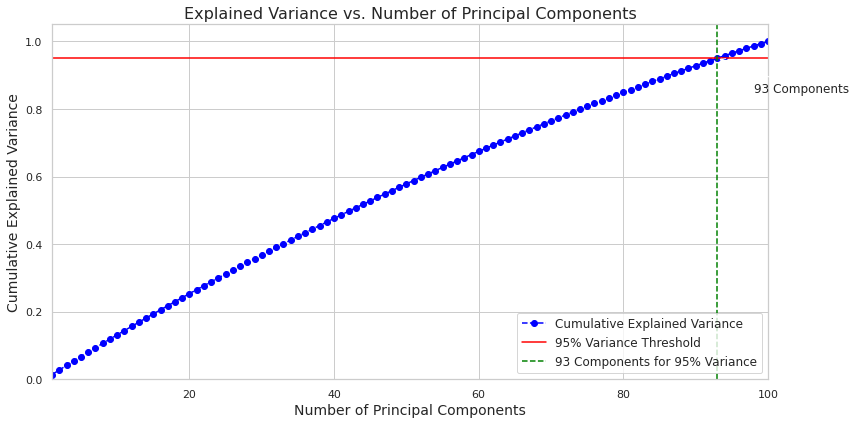

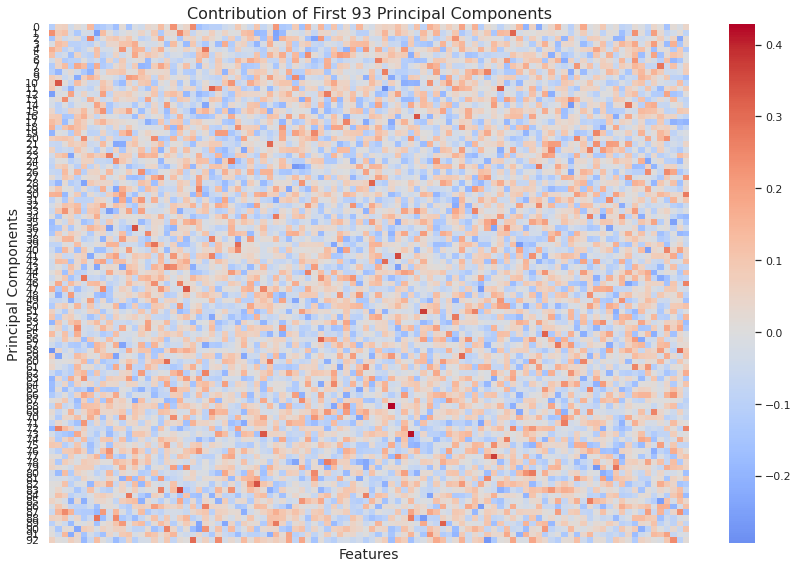

In [7]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Perform PCA on the KeyWordEmbeddings
pca = PCA()
pca.fit(KeyWordEmbeddings)  # Fit PCA model on the embeddings

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Set up the plot aesthetics using seaborn
sns.set_theme(style="whitegrid")

# Create the figure and axis objects for cumulative variance plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot cumulative variance with markers
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linestyle='--', label='Cumulative Explained Variance', color='blue')

# Highlight the point where 95% variance is explained
components_95 = np.argmax(cumulative_variance >= 0.95) + 1
ax.axhline(y=0.95, color='red', linestyle='-', label='95% Variance Threshold')
ax.axvline(x=components_95, color='green', linestyle='--', 
           label=f'{components_95} Components for 95% Variance')

# Add annotations for clarity
ax.annotate(f'{components_95} Components', 
            xy=(components_95, 0.95), 
            xytext=(components_95 + 5, 0.85),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12)

# Customize the plot
ax.set_title('Explained Variance vs. Number of Principal Components', fontsize=16)
ax.set_xlabel('Number of Principal Components', fontsize=14)
ax.set_ylabel('Cumulative Explained Variance', fontsize=14)
ax.set_xlim(1, len(cumulative_variance))
ax.set_ylim(0.0, 1.05)
ax.legend(loc='lower right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Heatmap to visualize contribution of principal components
contribution_matrix = pca.components_[:components_95]
plt.figure(figsize=(12, 8))
sns.heatmap(contribution_matrix, cmap='coolwarm', center=0, 
            annot=False, fmt=".2f", xticklabels=False, yticklabels=True)
plt.title(f'Contribution of First {components_95} Principal Components', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Principal Components', fontsize=14)
plt.tight_layout()
plt.show()


### 2.2 Feature Evaluation and PCA on Genre Embeddings

Mutual Information between Title Embeddings and IMDb Score Bins:
[0.         0.00318005 0.00043153 0.00956551 0.00082238 0.01532995
 0.00785553 0.00772514 0.00122103 0.01126045 0.00532958 0.00189026
 0.         0.00849027 0.01946228 0.02647774 0.00465644 0.00343097
 0.00056887 0.00523408 0.03021029 0.01006745 0.00232388 0.
 0.02669065 0.         0.00651661 0.01362896 0.01471979 0.02457737
 0.         0.01879296 0.         0.01683522 0.         0.01686168
 0.0193818  0.         0.01306168 0.01770906 0.01036057 0.01673082
 0.01268001 0.01469227 0.02761664 0.02124814 0.01661745 0.00861722
 0.         0.0078576  0.03214245 0.00512466 0.         0.
 0.01051197 0.00728574 0.0054488  0.00016415 0.01620285 0.01090512
 0.02384988 0.02059718 0.00729989 0.02668568 0.         0.00949239
 0.00611889 0.02166585 0.01433278 0.00737139 0.02039322 0.01015921
 0.01303125 0.01593818 0.02412025 0.00582146 0.         0.01505634
 0.00151585 0.02482412 0.01829345 0.01594238 0.         0.01143285
 0.01301603 0

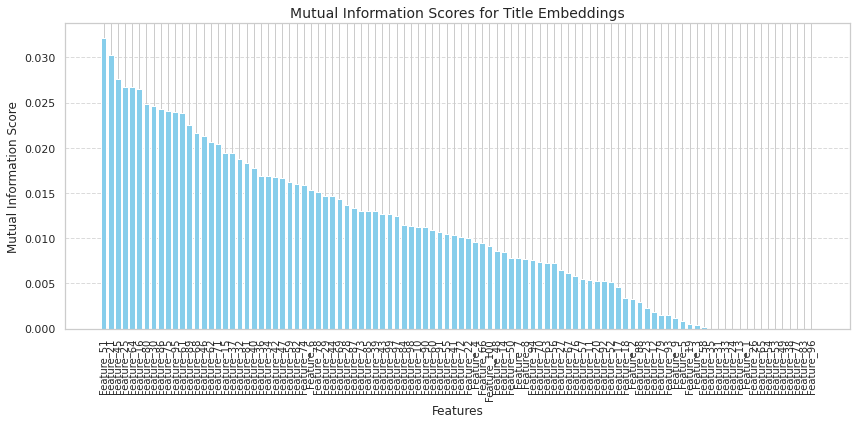





Explained Variance Ratio for Genre Embeddings PCA:
[0.05979388 0.04931599 0.04398562 0.040113   0.03632348 0.03011112
 0.02579819 0.02374498 0.02300882 0.02224901 0.02085838 0.0206749
 0.01838038 0.01752673 0.01725465 0.01649141 0.01550936 0.01492007
 0.01465154 0.0142897  0.01386025 0.01322946 0.01277429 0.01240492
 0.01193996 0.01176254 0.01127166 0.01113133 0.01077045 0.01062245
 0.00993203 0.00989217 0.00935785 0.00932682 0.00912413 0.00890862
 0.00884674 0.00861021 0.00827011 0.00786227 0.0078334  0.00766573
 0.00761226 0.00733602 0.00723136 0.00715692 0.00684287 0.0066426
 0.00645875 0.00627899 0.0061728  0.00610893 0.00602293 0.00579256
 0.00576718 0.00559874 0.00548002 0.00538618 0.00527898 0.00515794
 0.00512157 0.0050098  0.00490471 0.00480279 0.00464384 0.00458996
 0.00456921 0.00448806 0.00440174 0.00425279 0.00419888 0.00402557
 0.00401673 0.00393789 0.00386594 0.00377643 0.00372221 0.00359696
 0.00352352 0.00331599 0.00326344 0.00318361 0.00310899 0.00306072
 0.002983

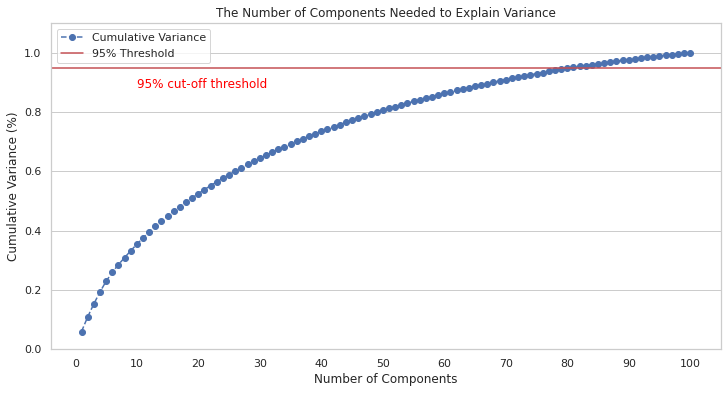

In [8]:
# Evaluate mutual information between title embeddings and binned IMDb scores
print("Mutual Information between Title Embeddings and IMDb Score Bins:")
mi_scores = mutual_info_classif(TitleEmbeddings, Train["imdb_score_binned"])
print(mi_scores)

# Calculate mutual information scores
mi_scores = mutual_info_classif(TitleEmbeddings, Train["imdb_score_binned"])

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': [f'Feature_{i+1}' for i in range(len(mi_scores))], 'MI Score': mi_scores})

# Sort the DataFrame by MI scores in descending order for better insights
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Plot the mutual information scores as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(mi_df['Feature'], mi_df['MI Score'], color='skyblue')

# Add plot labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.title('Mutual Information Scores for Title Embeddings', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

print('\n\n\n')

# Perform PCA on GenreEmbeddings
pca = PCA()
pca.fit(GenreEmbeddings)

# Print the explained variance ratio for PCA
print("Explained Variance Ratio for Genre Embeddings PCA:")
print(pca.explained_variance_ratio_)

# Plot cumulative explained variance for GenreEmbeddings
plt.rcParams["figure.figsize"] = (12, 6)  # Set the figure size

fig, ax = plt.subplots()

# x-axis: Component indices (1-based for human readability)
xi = np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1)

# y-axis: Cumulative sum of explained variance ratios
y = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.ylim(0.0, 1.1)  # Set y-axis range
plt.plot(xi, y, marker='o', linestyle='--', color='b', label='Cumulative Variance')

# Add plot labels and title
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(pca.explained_variance_ratio_) + 1, step=10))  # Adjust step size if needed
plt.ylabel('Cumulative Variance (%)')
plt.title('The Number of Components Needed to Explain Variance')

# Add reference line for the 95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.text(10, 0.88, '95% cut-off threshold', color='red', fontsize=12)

# Add gridlines and legend for clarity
ax.grid(axis='x')
plt.legend()

# Display the plot
plt.show()

### 2.3: Partial Least Squares (PLS) Regression and Component Analysis

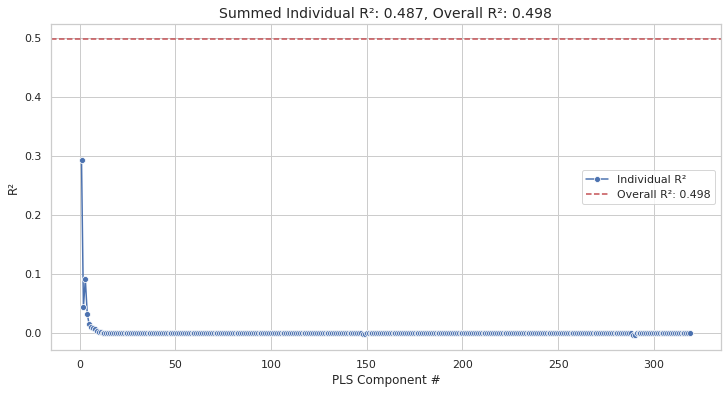

KeyboardInterrupt: 

In [9]:
# Standardize the features and target variable
X_scaled = S_TotalDataPlusGenreEmbeddings
y_scaled = Train["imdb_score_binned"].values.reshape(-1, 1).ravel()

# Fit PLS regression with standardized data
pls = PLSRegression(n_components=len(S_TotalDataPlusGenreEmbeddings.columns) - 1, max_iter=100000)
pls.fit(X_scaled, y_scaled)

# Evaluate R² for individual components and overall performance
def pls_explained_variance(pls, X, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    x_transformed = pls.transform(X)
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(x_transformed[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)
    
    overall_r2 = r2_score(Y_true, pls.predict(X))

    if do_plot:
        import seaborn as sns
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=np.arange(1, pls.n_components + 1), y=r2, marker='o', label='Individual R²')
        plt.axhline(overall_r2, color='r', linestyle='--', label=f'Overall R²: {overall_r2:.3f}')
        plt.xlabel('PLS Component #', fontsize=12)
        plt.ylabel('R²', fontsize=12)
        plt.title(f'Summed Individual R²: {np.sum(r2):.3f}, Overall R²: {overall_r2:.3f}', fontsize=14)
        plt.legend()
        plt.show()

    return r2, overall_r2

# Evaluate and plot explained variance
r2, overall_r2 = pls_explained_variance(pls, X_scaled, y_scaled, do_plot=True)

# Find the optimal number of PLS components using cross-validation
best_r2 = float('-inf')
best_n_components = 0

for n in range(1, 40):  # Test components from 1 to 20
    pls = PLSRegression(n_components=n)
    scores = cross_val_score(pls, X_scaled, y_scaled, cv=5, scoring='r2')
    mean_r2 = np.mean(scores)
    # print(f"Components: {n}, Mean R²: {mean_r2:.3f}")
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_n_components = n

print(f"Best number of components: {best_n_components}, Best R²: {best_r2:.3f}")

# Fit PLS with the optimal number of components
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_scaled, y_scaled)
r2, overall_r2 = pls_explained_variance(pls, X_scaled, y_scaled, do_plot=True)


# Calculate cumulative variance for selected components
PLScomponents = pls.transform(X_scaled)
tempList = []
for i in range(1, best_n_components + 1):
    Itemp = PLScomponents[:, i - 1]
    Jtemp = y_scaled
    tempList.append(np.abs(np.cov(Itemp, Jtemp)[1, 0]))

# Plot cumulative variance explained by components
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
xi = np.arange(1, best_n_components + 1, step=1)
y = np.cumsum(tempList) / sum(tempList)

# Calculate cumulative variance for selected components
PLScomponents = pls.transform(X_scaled)
tempList = []
for i in range(1, best_n_components + 1):
    Itemp = PLScomponents[:, i - 1]
    Jtemp = y_scaled
    tempList.append(np.abs(np.cov(Itemp, Jtemp)[1, 0]))

# Plot cumulative variance explained by components
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
xi = np.arange(1, best_n_components + 1, step=1)
y = np.cumsum(tempList) / sum(tempList)

n_comp_95 = np.argmax(y >= 0.95) + 1

# Existing plot code
sns.lineplot(x=xi, y=y, marker='o', linestyle='--', color='b', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Cut-off Threshold')

# Existing vertical line/text for best_n_components
plt.vlines(best_n_components, 0, 1.2, linestyles='dotted', colors='gray', 
           label=f'Selected Components ({best_n_components})')
plt.text(best_n_components + 0.5, 0.5, f'{best_n_components} Best R² Components', 
         color='black', fontsize=10)

plt.vlines(n_comp_95, 0, 1.2, linestyles='--', colors='green',
           label=f'95% Variance at {n_comp_95} Components')
plt.text(n_comp_95 + 0.5, 0.4, f'{n_comp_95} Components for 95% Var',
         color='green', fontsize=10)

plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance (%)', fontsize=12)
plt.title('Cumulative Variance Explained by Selected Components', fontsize=14)
plt.legend()
plt.show()


## Section 3: Dataset Selection

### 3.1 Baseline Whole Dataset Evaluation with Cross-Validation

In [10]:
class DatasetWrapper:
    def __init__(self, name, X_train, y_train, X_test, y_test):
        self.name = name
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

# Create your dataset wrappers (replace with your own variables)
datasets = [
    DatasetWrapper(
        "TotalData",
        X_train_S_TotalData,
        y_train_S_TotalData,
        X_test_S_TotalData,
        y_test_S_TotalData
    ),
    DatasetWrapper(
        "TotalDataPlusGenreEncodings",
        X_train_S_TotalDataPlusGenreEncoding,
        y_train_S_TotalDataPlusGenreEncoding,
        X_test_S_TotalDataPlusGenreEncoding,
        y_test_S_TotalDataPlusGenreEncoding
    ),
    DatasetWrapper(
        "TotalDataPlusGenreEmbeddings",
        X_train_S_TotalDataPlusGenreEmbeddings,
        y_train_S_TotalDataPlusGenreEmbeddings,
        X_test_S_TotalDataPlusGenreEmbeddings,
        y_test_S_TotalDataPlusGenreEmbeddings
    )
]

# Define the models to evaluate
models = [
    ("Logistic Regression", LogisticRegression(max_iter=100000)),
    ("Support Vector Classifier (SVC)", SVC())
]


# Function to evaluate models on multiple datasets with cross-validation
def evaluate_models_on_splits(datasets, models):
    """
    Evaluate multiple models on multiple train-test splits.

    Parameters:
    - datasets: List of DatasetWrapper objects, each containing X_train, y_train, X_test, y_test
    - models: List of (model_name, model_instance) tuples

    Prints out the accuracy on the test set for each dataset and each model.
    """
    for ds in datasets:
        print(f"\nEvaluating Dataset: {ds.name}")
        for model_name, model in models:
            # Fit the model on the train set
            model.fit(ds.X_train, ds.y_train)
            # Predict on the test set
            y_pred = model.predict(ds.X_test)
            # Calculate test accuracy
            accuracy = accuracy_score(ds.y_test, y_pred)
            print(f"  Model: {model_name} | Test Accuracy: {accuracy:.4f}")



# Run the evaluation
evaluate_models_on_splits(datasets, models)



Evaluating Dataset: TotalData
  Model: Logistic Regression | Test Accuracy: 0.6972
  Model: Support Vector Classifier (SVC) | Test Accuracy: 0.6872

Evaluating Dataset: TotalDataPlusGenreEncodings
  Model: Logistic Regression | Test Accuracy: 0.6922
  Model: Support Vector Classifier (SVC) | Test Accuracy: 0.7072

Evaluating Dataset: TotalDataPlusGenreEmbeddings
  Model: Logistic Regression | Test Accuracy: 0.6672
  Model: Support Vector Classifier (SVC) | Test Accuracy: 0.6805


### 3.2 Feature Selection Using Ablation Approach

In [23]:
def accuracy_SVM(X, Y, Xt, Yt):
    """
    Trains an SVM on (X, Y) and returns accuracy on (Xt, Yt).
    """
    clf = SVC()
    clf.fit(X, Y)
    return clf.score(Xt, Yt)

def accuracy_Logistic(X, Y, Xt, Yt):
    """
    Trains a Logistic Regression on (X, Y) and returns accuracy on (Xt, Yt).
    """
    clf = LogisticRegression(max_iter=100000, random_state=1273213)
    clf.fit(X, Y)
    return clf.score(Xt, Yt)

def f1_weighted_SVM(X, Y, Xt, Yt):
    clf = SVC(class_weight='balanced', random_state=1273213, max_iter=100000)
    clf.fit(X, Y)
    y_pred = clf.predict(Xt)
    return f1_score(Yt, y_pred, average='weighted')

def f1_weighted_Logistic(X, Y, Xt, Yt):
    clf = LogisticRegression(max_iter=100000, random_state=1273213, class_weight='balanced')
    clf.fit(X, Y)
    y_pred = clf.predict(Xt)
    return f1_score(Yt, y_pred, average='weighted')

def balanced_acc_SVM(X, Y, Xt, Yt):
    clf = SVC(class_weight='balanced', random_state=1273213, max_iter=100000)
    clf.fit(X, Y)
    y_pred = clf.predict(Xt)
    return balanced_accuracy_score(Yt, y_pred)

def balanced_acc_Logistic(X, Y, Xt, Yt):
    clf = LogisticRegression(max_iter=100000, random_state=1273213, class_weight='balanced')
    clf.fit(X, Y)
    y_pred = clf.predict(Xt)
    return balanced_accuracy_score(Yt, y_pred)

def f1_weighted_Ensemble(X, Y, Xt, Yt):
    svm = SVC(class_weight='balanced', random_state=1273213, max_iter=100000, probability=True)
    logistic = LogisticRegression(max_iter=100000, random_state=1273213, class_weight='balanced')
    
    ensemble = VotingClassifier(estimators=[
        ('svm', svm),
        ('logistic', logistic)
    ], voting='soft', n_jobs=-1)
    
    ensemble.fit(X, Y)
    y_pred = ensemble.predict(Xt)
    return f1_score(Yt, y_pred, average='weighted')

def balanced_acc_Ensemble(X, Y, Xt, Yt):
    svm = SVC(class_weight='balanced', random_state=1273213, max_iter=100000, probability=True)
    logistic = LogisticRegression(max_iter=100000, random_state=1273213, class_weight='balanced')
    
    ensemble = VotingClassifier(estimators=[
        ('svm', svm),
        ('logistic', logistic)
    ], voting='soft', n_jobs=-1)
    
    ensemble.fit(X, Y)
    y_pred = ensemble.predict(Xt)
    return balanced_accuracy_score(Yt, y_pred)




def ablationFeatureSelection(fullDataSet, 
                             targetSeries, 
                             scoreFunc, 
                             MaxOrMin, 
                             nSplits, 
                             threshold=False):
    """
    Given a dataset (fullDataSet) and a target (targetSeries),
    performs 1-step 'ablation': 
      1) Compute the baseline score across K-folds 
      2) For each feature, drop it and measure the new score
      3) Return the feature whose removal yields the "best" score 
         (depending on MaxOrMin), along with that score.
    """
    kf = KFold(n_splits=nSplits, random_state=10201331, shuffle=True)

    # 1) Compute baseline
    baseline_scores = []
    for train_index, test_index in kf.split(fullDataSet):
        X_train = fullDataSet.iloc[train_index]
        Y_train = targetSeries.iloc[train_index]
        X_test  = fullDataSet.iloc[test_index]
        Y_test  = targetSeries.iloc[test_index]
        baseline_scores.append(scoreFunc(X_train, Y_train, X_test, Y_test))
    baseline = stat.mean(baseline_scores)
    print("Ablation baseline score:", baseline)

    # 2) Check the score for removing each feature
    feature_scores = {}
    for col in fullDataSet.columns:
        tmpData = fullDataSet.drop(columns=[col], axis=1)
        tmp_scores = []
        for train_index, test_index in kf.split(tmpData):
            X_train = tmpData.iloc[train_index]
            Y_train = targetSeries.iloc[train_index]
            X_test  = tmpData.iloc[test_index]
            Y_test  = targetSeries.iloc[test_index]
            tmp_scores.append(scoreFunc(X_train, Y_train, X_test, Y_test))
        feature_scores[col] = stat.mean(tmp_scores)

    # 3) Return the column that yields the "best" (max or min) score
    if MaxOrMin == 'maxamise':
        best_val = max(feature_scores.values())
        best_cols = [c for c, val in feature_scores.items() if val == best_val]
    else:
        best_val = min(feature_scores.values())
        best_cols = [c for c, val in feature_scores.items() if val == best_val]

    chosen_col = random.choice(best_cols)  # pick one if there's a tie
    return chosen_col, feature_scores[chosen_col]


def buildUp(currFeatureSet, 
            fullDataSet, 
            targetSeries, 
            scoreFunc, 
            MaxOrMin, 
            nSplits, 
            threshold=False):
    """
    Attempt to 'build up' features one-by-one:
      - Start from currFeatureSet (possibly empty)
      - For each column not yet in currFeatureSet, 
        add it and compute the cross-validation score
      - Return the column that yields the best improvement.
    """
    kf = KFold(n_splits=nSplits, random_state=10201331, shuffle=True)
    
    # Evaluate each feature *not* in currFeatureSet
    candidate_scores = {}
    for col in fullDataSet.columns:
        if col in currFeatureSet:
            continue
        combo = currFeatureSet + [col]
        tmp_scores = []
        for train_index, test_index in kf.split(fullDataSet):
            X_train = fullDataSet[combo].iloc[train_index]
            Y_train = targetSeries.iloc[train_index]
            X_test  = fullDataSet[combo].iloc[test_index]
            Y_test  = targetSeries.iloc[test_index]
            tmp_scores.append(scoreFunc(X_train, Y_train, X_test, Y_test))
        candidate_scores[col] = stat.mean(tmp_scores)

    # If there are no candidates left, return None
    if len(candidate_scores) == 0:
        return None, None

    # Identify the best feature to add
    if MaxOrMin == 'maxamise':
        best_val = max(candidate_scores.values())
        best_cols = [c for c, val in candidate_scores.items() if val == best_val]
    else:
        best_val = min(candidate_scores.values())
        best_cols = [c for c, val in candidate_scores.items() if val == best_val]

    chosen_col = random.choice(best_cols)
    return chosen_col, candidate_scores[chosen_col]

random.seed = 10023913 

ablationAttempt = S_TotalDataPlusGenreEncoding.copy(deep=True)
currFeat = []
baseLineAccuracy = 0

# BUILD UP STAGE
while True:
    columnName, accuracy = buildUp(currFeat,
                                   ablationAttempt,
                                   Train["imdb_score_binned"],
                                   f1_weighted_Logistic,
                                   'maxamise',
                                   5)
    if (columnName is None) or (accuracy is None):
        # No more features to add
        break
    if accuracy < baseLineAccuracy:
        # Stopping if there's no improvement
        break
    print(f"Adding feature: {columnName}, new score = {accuracy}")
    currFeat.append(columnName)
    baseLineAccuracy = accuracy
    print("Current combo:", currFeat)

# ABLATION STAGE
baseline = baseLineAccuracy
while len(ablationAttempt[currFeat].columns) > 1:
    print("Ablation with feature set size:", len(currFeat))
    columnName, newScore = ablationFeatureSelection(
        ablationAttempt[currFeat], 
        Train["imdb_score_binned"], 
        f1_weighted_Logistic,
        'maxamise',
        5
    )
    if newScore < baseline:
        print(f"No improvement after trying to remove '{columnName}' (score {newScore} < baseline {baseline}). Stopping.")
        break
    print(f"Removing column: {columnName}, new ablation score = {newScore}")
    currFeat.remove(columnName)
    baseline = newScore

print("Final selected features:", currFeat)


Adding feature: num_voted_users, new score = 0.38599694752168207
Current combo: ['num_voted_users']
Adding feature: Drama, new score = 0.4791727422188904
Current combo: ['num_voted_users', 'Drama']
Adding feature: Americas, new score = 0.5167683544153876
Current combo: ['num_voted_users', 'Drama', 'Americas']
Adding feature: num_user_for_reviews, new score = 0.5448299675659698
Current combo: ['num_voted_users', 'Drama', 'Americas', 'num_user_for_reviews']
Adding feature: title_year, new score = 0.5581982059271221
Current combo: ['num_voted_users', 'Drama', 'Americas', 'num_user_for_reviews', 'title_year']
Adding feature: Action, new score = 0.5733545561990545
Current combo: ['num_voted_users', 'Drama', 'Americas', 'num_user_for_reviews', 'title_year', 'Action']
Adding feature: Documentary, new score = 0.5808241809600497
Current combo: ['num_voted_users', 'Drama', 'Americas', 'num_user_for_reviews', 'title_year', 'Action', 'Documentary']
Adding feature: Biography, new score = 0.58484109

### 3.3 Evaluation of Model on PLS Outcome

In [ ]:
kf = KFold(n_splits=20, random_state=10201331, shuffle=True)

avgScr = []
for train_index, test_index in kf.split(PLScomponents):
    # Slice the first n_comp_95 components for train and test
    X = PLScomponents[train_index, :n_comp_95]
    Y = Train["imdb_score_binned"].iloc[train_index]
    Xt = PLScomponents[test_index, :n_comp_95]
    Yt = Train["imdb_score_binned"].iloc[test_index]
    
    # Fit the Logistic Regression model
    clf = LogisticRegression(max_iter=100000)
    clf.fit(X, Y)
    
    # Evaluate on the test fold
    avgScr.append(clf.score(Xt, Yt))

# Print the mean accuracy across the 20 folds
print("Mean CV Accuracy:", stat.mean(avgScr))


## Section 4: Model Optimisation and Evaluation with Ablation Data Set

Performance Metrics:
F1-Score, Precision-Recall Area Under Curve (PR AUC), Balanced Accuracy, Confusion Matrix

In [15]:
''' SVM accuracy selection
 
  Adding feature: num_voted_users, new accuracy = 0.6597886855241264
 Current combo: ['num_voted_users']
 Adding feature: Drama, new accuracy = 0.6840881863560732
 Current combo: ['num_voted_users', 'Drama']
 Adding feature: title_year, new accuracy = 0.7010660011092624
 Current combo: ['num_voted_users', 'Drama', 'title_year']
 Adding feature: gross, new accuracy = 0.7120537992235164
 Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross']
 Adding feature: TitleEmb_93, new accuracy = 0.7177132556849696
 Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'TitleEmb_93']
 Adding feature: Documentary, new accuracy = 0.7200460343871325
 Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'TitleEmb_93', 'Documentary']
 Adding feature: Musical, new accuracy = 0.7213782584581254
 Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'TitleEmb_93', 'Documentary', 'Musical']
 Ablation with feature set size: 7
 Ablation baseline score: 0.7213782584581254
 No improvement after trying to remove 'Musical' (score 0.7200460343871325 < baseline 0.7213782584581254). Stopping.
 Final selected features: ['num_voted_users', 'Drama', 'title_year', 'gross', 'TitleEmb_93', 'Documentary', 'Musical']
'''

''' Logistic accuracy selection

Adding feature: num_voted_users, new accuracy = 0.6594564614531336
Current combo: ['num_voted_users']
Adding feature: Drama, new accuracy = 0.6834231835829173
Current combo: ['num_voted_users', 'Drama']
Adding feature: title_year, new accuracy = 0.6957398779811426
Current combo: ['num_voted_users', 'Drama', 'title_year']
Adding feature: gross, new accuracy = 0.7113871325568497
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross']
Adding feature: Action, new accuracy = 0.7173771491957849
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action']
Adding feature: Documentary, new accuracy = 0.7213743760399335
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary']
Adding feature: KWE_61, new accuracy = 0.7247043815862452
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61']
Adding feature: Asia, new accuracy = 0.7277021630615641
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia']
Adding feature: Animation, new accuracy = 0.7313627287853578
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation']
Adding feature: KWE_57, new accuracy = 0.7343605102606766
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57']
Adding feature: TitleEmb_56, new accuracy = 0.735691625069329
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'TitleEmb_56']
Adding feature: TitleEmb_6, new accuracy = 0.7366894065446479
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'TitleEmb_56', 'TitleEmb_6']
Adding feature: Music, new accuracy = 0.7370227398779812
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'TitleEmb_56', 'TitleEmb_6', 'Music']
Adding feature: Film-Noir, new accuracy = 0.7370232945091514
Current combo: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'TitleEmb_56', 'TitleEmb_6', 'Music', 'Film-Noir']
Ablation with feature set size: 14
Ablation baseline score: 0.7370232945091514
No improvement after trying to remove 'Film-Noir' (score 0.7370227398779812 < baseline 0.7370232945091514). Stopping.
Final selected features: ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'TitleEmb_56', 'TitleEmb_6', 'Music', 'Film-Noir']
'''

''' Logistic weighted accuracy selection

Adding feature: num_voted_users, new accuracy = 0.40937949670755064
Current combo: ['num_voted_users']
Adding feature: gross, new accuracy = 0.5132430023805099
Current combo: ['num_voted_users', 'gross']
Adding feature: Drama, new accuracy = 0.5633295299054134
Current combo: ['num_voted_users', 'gross', 'Drama']
Adding feature: cast_total_facebook_likes, new accuracy = 0.5801622794345427
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes']
Adding feature: num_user_for_reviews, new accuracy = 0.5956937018091311
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews']
Adding feature: num_critic_for_reviews, new accuracy = 0.6158451571348111
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews']
Adding feature: title_year, new accuracy = 0.63122734183215
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year']
Adding feature: KWE_14, new accuracy = 0.6481317928130881
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14']
Adding feature: duration, new accuracy = 0.6547820937240341
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration']
Adding feature: average_degree_centrality, new accuracy = 0.6578447684541728
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality']
Adding feature: TitleEmb_24, new accuracy = 0.661872196662387
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24']
Adding feature: TitleEmb_35, new accuracy = 0.6634514662012416
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35']
Adding feature: TitleEmb_77, new accuracy = 0.6653240192773076
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77']
Adding feature: TitleEmb_43, new accuracy = 0.6679770683683393
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43']
Adding feature: Mystery, new accuracy = 0.6688994335402391
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery']
Adding feature: War, new accuracy = 0.669704224611787
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War']
Adding feature: Western, new accuracy = 0.6702203820773973
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western']
Adding feature: Africa, new accuracy = 0.6703200578579425
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western', 'Africa']
Adding feature: KWE_61, new accuracy = 0.6703450611151022
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western', 'Africa', 'KWE_61']
Adding feature: TitleEmb_62, new accuracy = 0.6706294205460057
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western', 'Africa', 'KWE_61', 'TitleEmb_62']
Adding feature: KWE_84, new accuracy = 0.6712053213543973
Current combo: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western', 'Africa', 'KWE_61', 'TitleEmb_62', 'KWE_84']
Ablation with feature set size: 21
Ablation baseline score: 0.6712053213543973
Removing column: Africa, new ablation score = 0.6713497929317971
Ablation with feature set size: 20
Ablation baseline score: 0.6713497929317971
No improvement after trying to remove 'KWE_84' (score 0.6697033891039782 < baseline 0.6713497929317971). Stopping.
Final selected features: ['num_voted_users', 'gross', 'Drama', 'cast_total_facebook_likes', 'num_user_for_reviews', 'num_critic_for_reviews', 'title_year', 'KWE_14', 'duration', 'average_degree_centrality', 'TitleEmb_24', 'TitleEmb_35', 'TitleEmb_77', 'TitleEmb_43', 'Mystery', 'War', 'Western', 'KWE_61', 'TitleEmb_62', 'KWE_84']
'''

''' Logistic f1 selection


'''
final_features = ['num_voted_users', 'Drama', 'title_year', 'gross', 'Action', 'Documentary', 'KWE_61', 'Asia', 'Animation', 'KWE_57', 'Musical', 'TitleEmb_10', 'KWE_3']

### 4.1 Logistic Regression

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best CV balanced_accuracy: 0.4169158582780469
Test Balanced Accuracy: 0.4216317833639011


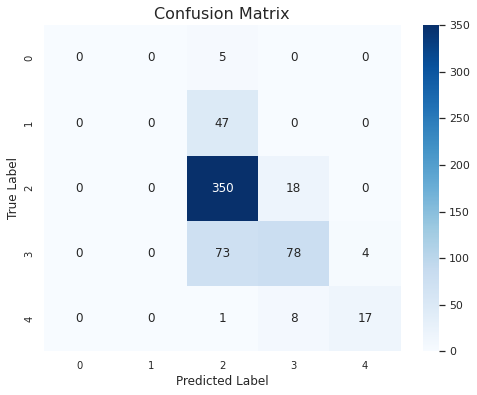


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        47
           2       0.74      0.95      0.83       368
           3       0.75      0.50      0.60       155
           4       0.81      0.65      0.72        26

    accuracy                           0.74       601
   macro avg       0.46      0.42      0.43       601
weighted avg       0.68      0.74      0.69       601



/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
X_train = X_train_S_TotalDataPlusGenreEncoding[final_features]
y_train = y_train_S_TotalDataPlusGenreEncoding

X_test = X_test_S_TotalDataPlusGenreEncoding[final_features]
y_test = y_test_S_TotalDataPlusGenreEncoding

# parameter grid
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],  # only solvers that support l1
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None]
    },
    {
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],  # solvers that support l2
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None]
    }
]


log_reg = LogisticRegression(random_state=1273213, max_iter=100000)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='balanced_accuracy',   
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # use all available cores
    verbose=1            
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearch
print("Best parameters:", grid_search.best_params_)
print("Best CV balanced_accuracy:", grid_search.best_score_)


best_model = grid_search.best_estimator_  # best estimator from grid search

y_pred = best_model.predict(X_test)

# Calculate test accuracy
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nTest balanced_accuracy:", test_balanced_acc)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", test_acc)

# Calculate test accuracy
test_f1 = f1_score(y_test, y_pred)
print("\nTest f1:", test_f1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))  # set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)

# Adjust tick label size (optional)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### 4.3 SVC (SVM classifier)

Starting Grid Search...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_

Grid Search Completed.
Best parameters: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
Best CV balanced_accuracy: 0.5568141508775729
Test balanced_accuracy: 0.5605848768372268


/home/hammatime123/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


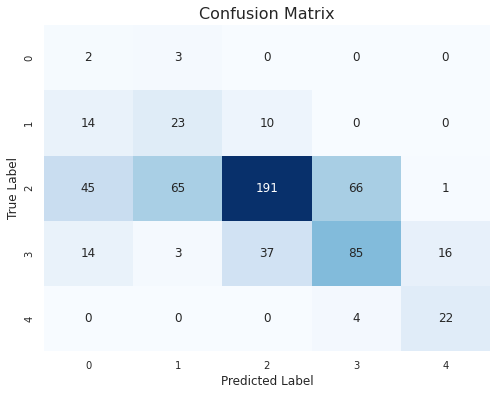


Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.40      0.05         5
           1       0.24      0.49      0.33        47
           2       0.80      0.52      0.63       368
           3       0.55      0.55      0.55       155
           4       0.56      0.85      0.68        26

    accuracy                           0.54       601
   macro avg       0.44      0.56      0.45       601
weighted avg       0.68      0.54      0.58       601



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming final_features, X_train_S_TotalDataPlusGenreEncoding, y_train_S_TotalDataPlusGenreEncoding,
# X_test_S_TotalDataPlusGenreEncoding, and y_test_S_TotalDataPlusGenreEncoding are already defined.

# Prepare the data
X_train = X_train_S_TotalDataPlusGenreEncoding[final_features]
y_train = y_train_S_TotalDataPlusGenreEncoding

X_test = X_test_S_TotalDataPlusGenreEncoding[final_features]
y_test = y_test_S_TotalDataPlusGenreEncoding

# Define the parameter grid for SVM
param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'class_weight': [None, 'balanced']
    },
    {
        'kernel': ['poly'],
        'degree': [2, 3, 4],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'class_weight': [None, 'balanced']
    }
]

# Initialize the SVM classifier
svm_clf = SVC(random_state=1273213, max_iter=100000)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    scoring='balanced_accuracy',   # You can change this to 'f1_macro', 'balanced_accuracy', etc.
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # Use all available cores
    verbose=1             # Print progress
)

# Fit the grid search on the training data
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search Completed.")

# Print the best parameters found by GridSearch
print("Best parameters:", grid_search.best_params_)
print("Best CV balanced_accuracy:", grid_search.best_score_)

# Retrieve the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Test Accuracy
# Calculate test accuracy
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nTest balanced_accuracy:", test_balanced_acc)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", test_acc)

# Calculate test accuracy
test_f1 = f1_score(y_test, y_pred)
print("\nTest f1:", test_f1)

# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### 4.2 Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/hammatime123/.local/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best CV balanced_accuracy: 0.5219120399037326
Test Accuracy: 0.53435124631866


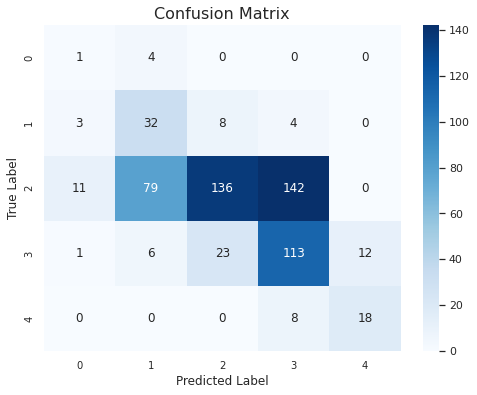


Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.20      0.10         5
           1       0.26      0.68      0.38        47
           2       0.81      0.37      0.51       368
           3       0.42      0.73      0.54       155
           4       0.60      0.69      0.64        26

    accuracy                           0.50       601
   macro avg       0.43      0.53      0.43       601
weighted avg       0.65      0.50      0.51       601



In [27]:
# Example param grid
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [None, 5, 10],          # Tree depth
    'max_features': ['sqrt', 'log2'],    # Features to consider at each split
    'min_samples_split': [2, 5],         # Min # of samples to split a node
    'min_samples_leaf': [1, 2, 4],       # Min # of samples at a leaf node
    'class_weight': [None, 'balanced'],  # Class imbalance handling
}

# Create a RandomForestClassifier (baseline model)
rf = RandomForestClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='balanced_accuracy',   # or 'f1_macro', etc.
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # use all available CPU cores
    verbose=1             # print progress messages
)

# Fit on the training set
grid_search.fit(X_train, y_train)

# Print out the best hyperparameters from the grid search
print("Best parameters found:", grid_search.best_params_)
print("Best CV balanced_accuracy:", grid_search.best_score_)

# Retrieve the best model from the grid search
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Evaluate
# Calculate test accuracy
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nTest balanced_accuracy:", test_balanced_acc)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", test_acc)

# Calculate test accuracy
test_f1 = f1_score(y_test, y_pred)
print("\nTest f1:", test_f1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))  # set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)

# Adjust tick label size (optional)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### 4.3 Gradient Boosting (XGBoost)

In [29]:
import xgboost as xgb
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


param_grid = {
    'n_estimators':      [100, 200, 300],
    'learning_rate':     [0.01, 0.1, 0.2],
    'max_depth':         [3, 5, 7],
    'subsample':         [0.8, 1.0],
    'colsample_bytree':  [0.8, 1.0],
    'min_child_weight':  [1, 3],
    'gamma':             [0, 1],
    'scale_pos_weight':  [1, 5, 10]
}


xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',        
    use_label_encoder=False,
    random_state=42
)


grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='balanced_accuracy',    
    cv=5,                  
    n_jobs=-1,         
    verbose=1             
)


grid_search.fit(X_train, y_train)

# Print best hyperparameters and CV score
print("Best parameters found:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_

# Predict on the test set
y_pred = best_xgb.predict(X_test)

# Calculate test accuracy
test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nTest balanced_accuracy:", test_balanced_acc)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", test_acc)

# Calculate test accuracy
test_f1 = f1_score(y_test, y_pred)
print("\nTest f1:", test_f1)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/home/hammatime123/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/hammatime123/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/hammatime123/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/hammatime123/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/hammat

Best parameters found: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'scale_pos_weight': 1, 'subsample': 0.8}
Best CV score: 0.4373757849269572

Test balanced_accuracy: 0.42170112339690985

Test balanced_accuracy: 0.7138103161397671


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

### 4.4 Neural Network

In [ ]:
import sys
import torch
import torch.nn.functional as F
import torch.utils.data as dataUtils

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt

import time


class NeuralNetwork(torch.nn.Module):
    def __init__(self, nInputs, l1, l2, l3, nClasses):
        super(NeuralNetwork, self).__init__()
        self.Numerical = torch.nn.Sequential(
            torch.nn.Linear(20, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings1 = torch.nn.Sequential(
            torch.nn.Linear(100, 20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings2 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings3 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Combination = torch.nn.Sequential(
            torch.nn.Linear(40,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(10,nClasses),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        a = self.Numerical(x[:,0:20])
        b = self.Embeddings1(x[:,20:120])
        c = self.Embeddings2(x[:,120:220])
        d = self.Embeddings3(x[:,220:320])
        combined = torch.cat((a,b,c,d), dim=1)
        out = self.Combination(combined)
        return out

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data

        with torch.no_grad():
            logits = model(x)
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))


def train(model, train_loader, test_loader, optimizer, n_epochs=10):
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):

        epoch_loss = 0.

        for i, data in enumerate(train_loader):

            x, labels = data

            logits = model(x)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, labels).float()).item()

            loss = criterion(input=logits, target=labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, test_loader)
    return running_loss, running_accuracy


xTrain, xTest, yTrain, yTest = train_test_split(TotalDataPlusGenreEmbeddings, Train["imdb_score_binned"], test_size=0.2, random_state=981488)

xTrain = torch.tensor(xTrain.values, dtype=torch.float)
yTrain = torch.tensor(yTrain.values).type(torch.LongTensor)
trainData = dataUtils.TensorDataset(xTrain, yTrain)
trainLoader = dataUtils.DataLoader(trainData, batch_size=128, shuffle=True)

xTest = torch.tensor(xTest.values, dtype=torch.float)
yTest = torch.tensor(yTest.values).type(torch.LongTensor)
testData = dataUtils.TensorDataset(xTest, yTest)
testLoader = dataUtils.DataLoader(testData, batch_size=128, shuffle=False)

neuralNetwork = NeuralNetwork(len(TotalDataPlusGenreEmbeddings.columns), 150, 100, 50, 5)

optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=1e-2, momentum=0.5)

nnLoss, nnAcc = train(neuralNetwork, trainLoader, testLoader, optimizer, 100)

plt.plot(nnLoss)
plt.xlabel("iterations")
plt.ylabel("Cross-entropy Loss (Train)")
plt.show()

plt.plot(nnAcc)
plt.xlabel("iterations")
plt.ylabel("Accuracy (Train)")
plt.show()